<a href="https://colab.research.google.com/github/aekanun2020/2023-Data-Science-for-Social-Commerce/blob/main/2023_Prediction_of_Customer_Behavior_with_DataViz-Rev0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Spark Environment

In [104]:
# Install necessary packages
!pip install pyspark==3.2.0

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Create SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libraries and Modules Installation

In [105]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

## Data Collection

In [151]:
#! wget https://storage.googleapis.com/22may2023/testfunnel.csv
! wget https://storage.googleapis.com/aekanunlab/funneldata.zip

--2023-05-20 12:11:01--  https://storage.googleapis.com/aekanunlab/funneldata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111701790 (107M) [application/zip]
Saving to: ‘funneldata.zip’

funneldata.zip      100%[===================>] 106.53M  76.5MB/s    in 1.4s    

2023-05-20 12:11:02 (76.5 MB/s) - ‘funneldata.zip’ saved [111701790/111701790]



In [152]:
! unzip funneldata.zip

Archive:  funneldata.zip
  inflating: 000000000000            
  inflating: 000000000001            
  inflating: 000000000002            
  inflating: 000000000003            
  inflating: 000000000004            
  inflating: 000000000005            
  inflating: 000000000006            
  inflating: 000000000007            
  inflating: 000000000008            
  inflating: 000000000009            


In [162]:
#! head -3 testfunnel.csv
! head -3 000000000000

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [161]:
#! wc -l testfunnel.csv
! wc -l 000000000000

917815 000000000000


In [163]:
raw_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./000000000000')

# 1. Business Understanding

**ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

In [164]:
business_requiredCol_list = [x for x in raw_df.columns]

In [165]:
customerBehaviorCol_list = [x for x in raw_df.columns \
         if ((x != 'sourceKeyword')&(x != 'fullVisitorId')&(x != 'isVideoAd')&(x != 'date')\
             &(x != 'isTrueDirect')&(x != 'hitHour')&(x != 'hitMin')&(x != 'isClick')\
             &(x != 'productListName')&(x != 'isImpression')&(x != 'sessionQualityDim')&(x != 'timeOnScreen')\
             &(x != 'hitReferer')&(x != 'medium')&(x != 'hitType'))]

# 2. Data Understanding

### Previewing Data

In [166]:
raw_df.count()

917814

In [167]:
len(raw_df.columns)

24

In [168]:
raw_df.sample(0.001).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,915,916,917,918,919,920,921,922,923,924
source,(direct),google,(direct),google,google,google,images.google,(direct),google,google,...,Partners,(direct),(direct),(direct),(direct),youtube.com,(direct),google,(direct),(direct)
isTrueDirect,None,None,True,None,None,None,None,None,True,None,...,None,True,None,True,True,None,True,None,True,True
sourceKeyword,None,(not provided),None,(not provided),(not provided),(not provided),(not provided),None,(not provided),(not provided),...,None,None,None,None,None,None,None,(not provided),None,None
medium,(none),organic,(none),organic,organic,organic,organic,(none),organic,organic,...,affiliate,(none),(none),(none),(none),referral,(none),organic,(none),(none)
isVideoAd,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
fullVisitorId,4990198874063509353,4990634285393940076,4990803917337260315,4990955117732204143,4992499749003799871,4992970334133037215,4993667846900005320,4993852637585406336,4995239461409228195,4995584940873803432,...,5480804741786670724,5482537884347174224,5482641824187511686,5482909256031860287,5482909256031860287,5483455978472808813,5485910827614119273,5485994070074079188,5486423312788260329,5487223739597049238
visitId,1477021389,1496560463,1476202026,1490136764,1472235854,1474383410,1481114338,1489938502,1487299362,1494938090,...,1486819217,1493674440,1480749705,1473281534,1473281534,1491437938,1470325196,1489817167,1478037693,1487115852
date,20161020,20170604,20161011,20170321,20160826,20160920,20161207,20170319,20170216,20170516,...,20170211,20170501,20161202,20160907,20160907,20170405,20160804,20170317,20161101,20170214
newVisits,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
hitReferer,None,https://www.google.co.th/,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,https://www.google.it/,None,None


In [169]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransac

### Exploratory Data Analysis - Univariate Analysis



In [170]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549944986E18,1.4270756141027817E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975134656,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428260378,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitReferer,119959,None,None,http://googleads.g.doubleclick.net/pagead/ads?...,https://youtube.com/yt/about/copyright/
hitType,917814,None,None,EVENT,PAGE


In [171]:
from pyspark.sql.types import IntegerType, FloatType

numeric_columns = []
non_numeric_columns = []

for col_name in raw_df.columns:
    # Check if the column type is numeric
    if isinstance(raw_df.schema[col_name].dataType, IntegerType) or isinstance(raw_df.schema[col_name].dataType, FloatType):
        numeric_columns.append(col_name)
    else:
        non_numeric_columns.append(col_name)

print(f"Numeric columns: {numeric_columns}")
print(f"Non-numeric columns: {non_numeric_columns}")


Numeric columns: ['visitId', 'date', 'newVisits', 'hitAction_type', 'hitNumber', 'hitHour', 'hitMin', 'timeMicroSec', 'sessionQualityDim', 'timeOnSite']
Non-numeric columns: ['source', 'isTrueDirect', 'sourceKeyword', 'medium', 'isVideoAd', 'fullVisitorId', 'hitReferer', 'hitType', 'v2ProductName', 'productListName', 'isClick', 'isImpression', 'timeOnScreen', 'totalTransactionRevenue']


In [172]:
numeric_columns

['visitId',
 'date',
 'newVisits',
 'hitAction_type',
 'hitNumber',
 'hitHour',
 'hitMin',
 'timeMicroSec',
 'sessionQualityDim',
 'timeOnSite']

In [173]:
non_numeric_columns

['source',
 'isTrueDirect',
 'sourceKeyword',
 'medium',
 'isVideoAd',
 'fullVisitorId',
 'hitReferer',
 'hitType',
 'v2ProductName',
 'productListName',
 'isClick',
 'isImpression',
 'timeOnScreen',
 'totalTransactionRevenue']

In [174]:
from pyspark.sql.functions import count, when, isnan, col
# Check for null values
raw_df.select(numeric_columns).select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                       for c in raw_df.select(numeric_columns).columns]).toPandas().transpose()

,0
visitId,0
date,0
newVisits,270455
hitAction_type,0
hitNumber,0
hitHour,0
hitMin,0
timeMicroSec,0
sessionQualityDim,856032
timeOnSite,67305


In [175]:
raw_df.groupBy('sessionQualityDim').count().show()

## สังเกตว่า หลักการเรื่อง Imputation ด้วย Avg หรือ Agg.func. ไม่สามารถนำมาใช้ได้เสมอไป
## ลองคิดดูว่า หาก Avg('sessionQualityDim') แล้วได้ค่าหนึ่ง คำถามคือ ค่านั้นนำมาแทน null
## จริงหรือ?

+-----------------+-----+
|sessionQualityDim|count|
+-----------------+-----+
|               85|  250|
|               53|  366|
|               78|  134|
|               34|  269|
|               81|  427|
|               76|  492|
|               27|  128|
|               44|  596|
|               12|  451|
|               91|  148|
|               22|  189|
|               47|  184|
|                1|28967|
|               52|   37|
|               13|  141|
|               16|  248|
|                6|  824|
|               86|   86|
|                3| 1816|
|               20|  185|
+-----------------+-----+
only showing top 20 rows



In [176]:
raw_df.groupBy('newVisits').count().show()

+---------+------+
|newVisits| count|
+---------+------+
|        1|647359|
|     null|270455|
+---------+------+



In [177]:
from pyspark.sql import functions as sparkf

noNull_df = raw_df.withColumn('newVisits',sparkf.when(sparkf.col('newVisits').isNull(),'NA')\
                  .otherwise(sparkf.col('newVisits')))\
                  .withColumn('sessionQualityDim',sparkf.when(sparkf.col('sessionQualityDim').isNull(),'NA')\
                  .otherwise(sparkf.col('sessionQualityDim')))\
                  .withColumn('timeOnSite',sparkf.when(sparkf.col('timeOnSite').isNull(),0)\
                  .otherwise(sparkf.col('timeOnSite')))\
                  .withColumn('totalTransactionRevenue',sparkf.when(sparkf.col('totalTransactionRevenue').isNull(),0)\
                  .otherwise(sparkf.col('totalTransactionRevenue')))

In [178]:
noNull_df.select(numeric_columns).select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                       for c in noNull_df.select(numeric_columns).columns]).toPandas().transpose()

,0
visitId,0
date,0
newVisits,0
hitAction_type,0
hitNumber,0
hitHour,0
hitMin,0
timeMicroSec,0
sessionQualityDim,0
timeOnSite,0


In [179]:
### raw_df.printSchema()

In [180]:
### noNull_df.printSchema()

In [181]:
from pyspark.sql.types import IntegerType, FloatType

numeric_columns = []
non_numeric_columns = []

for col_name in noNull_df.columns:
    # Check if the column type is numeric
    if isinstance(noNull_df.schema[col_name].dataType, IntegerType) or isinstance(noNull_df.schema[col_name].dataType, FloatType):
        numeric_columns.append(col_name)
    else:
        non_numeric_columns.append(col_name)

print(f"Numeric columns: {numeric_columns}")
print(f"Non-numeric columns: {non_numeric_columns}")

Numeric columns: ['visitId', 'date', 'hitAction_type', 'hitNumber', 'hitHour', 'hitMin', 'timeMicroSec', 'timeOnSite']
Non-numeric columns: ['source', 'isTrueDirect', 'sourceKeyword', 'medium', 'isVideoAd', 'fullVisitorId', 'newVisits', 'hitReferer', 'hitType', 'v2ProductName', 'productListName', 'isClick', 'isImpression', 'sessionQualityDim', 'timeOnScreen', 'totalTransactionRevenue']


In [182]:
from pyspark.sql.functions import col

# Calculate Q1, Q3, and IQR for each numeric column
for col_name in numeric_columns:
    quantiles = raw_df.stat.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Filter values out of the (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) range
    outliers = raw_df.filter((col(col_name) < Q1 - 1.5 * IQR) | (col(col_name) > Q3 + 1.5 * IQR))
    print(f"Column {col_name} has {outliers.count()} outliers")


Column visitId has 0 outliers
Column date has 0 outliers
Column hitAction_type has 63911 outliers
Column hitNumber has 107855 outliers
Column hitHour has 0 outliers
Column hitMin has 0 outliers
Column timeMicroSec has 100803 outliers
Column timeOnSite has 92507 outliers


In [183]:
from pyspark.sql.functions import log

# Initialize DataFrame
takeLog_df = noNull_df

# Loop through each numeric column and take log to fix skewness
for col in numeric_columns:
    takeLog_df = takeLog_df.withColumn(col, log(takeLog_df[col]))

# Check outliers
for col in numeric_columns:
    bounds = {
        c: dict(
            zip(["q1", "q3"], takeLog_df.approxQuantile(c, [0.25, 0.75], 0))
        )
        for c in [col]
    }

    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
        print(f"Column {c} has {takeLog_df.filter((takeLog_df[c] < bounds[c]['lower']) | (takeLog_df[c] > bounds[c]['upper'])).count()} outliers")


Column visitId has 0 outliers
Column date has 0 outliers
Column hitAction_type has 0 outliers
Column hitNumber has 122 outliers
Column hitHour has 57903 outliers
Column hitMin has 42814 outliers
Column timeMicroSec has 1471 outliers
Column timeOnSite has 8389 outliers


In [184]:
numeric_columns

['visitId',
 'date',
 'hitAction_type',
 'hitNumber',
 'hitHour',
 'hitMin',
 'timeMicroSec',
 'timeOnSite']

In [185]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, abs, udf

# สร้าง UDF (User Defined Function) ในการแปลง Vector เป็น float
vector_to_float_udf = udf(lambda vector: float(vector[0]), FloatType())

# สร้าง StandardScaler object
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# เริ่มต้นด้วย DataFrame ที่ไม่มี Null
zScore_df = noNull_df

# สร้าง dataframe ที่จะถูก scale
for c in numeric_columns:
    # ใส่คอลัมน์ที่คำนวณได้ลงใน VectorAssembler
    assembler = VectorAssembler(inputCols=[c], outputCol="features")
    output = assembler.transform(zScore_df)
    
    # คำนวณ statistics และแปลง data ด้วย StandardScaler
    scalerModel = scaler.fit(output)
    scaledData = scalerModel.transform(output)
    
    # เพิ่ม column z-score ไปยัง dataframe ที่มีอยู่แล้ว
    zScore_df = scaledData.withColumn(f'{c}_zscore', vector_to_float_udf('scaledFeatures'))
    
    # ลบคอลัมน์ที่ไม่ใช้แล้วออกจาก DataFrame
    zScore_df = zScore_df.drop('features', 'scaledFeatures')

# หา outlier ด้วยการแสดงรายการที่มี z-score > 3 หรือ < -3
for c in numeric_columns:
    outliers = zScore_df.filter((abs(col(f'{c}_zscore')) > 3))
    print(f'Column {c} has {outliers.count()} outliers')

# แสดง DataFrame ใหม่
zScore_df.show()



Column visitId has 0 outliers
Column date has 0 outliers
Column hitAction_type has 23345 outliers
Column hitNumber has 20012 outliers
Column hitHour has 0 outliers
Column hitMin has 0 outliers
Column timeMicroSec has 17646 outliers
Column timeOnSite has 18402 outliers
+------+------------+--------------+-------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+----------------+-------+------------+-----------------+------------+----------+-----------------------+--------------+-----------+---------------------+----------------+--------------+-------------+-------------------+-----------------+
|source|isTrueDirect| sourceKeyword| medium|isVideoAd|      fullVisitorId|   visitId|    date|newVisits|hitReferer|hitType|hitAction_type|hitNumber|hitHour|hitMin|timeMicroSec|       v2ProductName| productListName|isClick|isImpression|sessionQualityDim|timeOnScreen|timeOnSite|totalTransactionRev

In [186]:
from pyspark.sql.functions import col

# สร้าง DataFrame ใหม่เพื่อจัดการ outlier
filtered_dfs = {}
filtered_dfs[numeric_columns[0]] = noNull_df

# ทำการกรอง outliers ออกจาก DataFrame
for idx, c in enumerate(numeric_columns[1:], start=1):
    # คำนวณ IQR
    Q1, Q3 = filtered_dfs[numeric_columns[idx-1]].approxQuantile(c, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1

    # กำหนดระดับที่จะถือว่าเป็น outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # กรอง outliers ออกจาก DataFrame และสร้าง DataFrame ใหม่
    filtered_dfs[c] = filtered_dfs[numeric_columns[idx-1]].filter((col(c) >= lower_bound) & (col(c) <= upper_bound))

noOutlier_df = filtered_dfs[numeric_columns[-1]]

print(f"Number of rows after removing outliers: {noOutlier_df.count()}")


Number of rows after removing outliers: 625233


In [187]:
for a in business_requiredCol_list:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+------+
|              source| count|
+--------------------+------+
|            (direct)|502654|
|              google|320612|
|         youtube.com| 34750|
|            Partners|  9949|
|                 dfa|  8696|
|analytics.google.com|  6144|
|          google.com|  4537|
|    sites.google.com|  3866|
|siliconvalley.abo...|  3399|
|      m.facebook.com|  2283|
|        facebook.com|  2073|
|          reddit.com|  1978|
|     mail.google.com|  1833|
|                bing|  1543|
|           qiita.com|  1496|
|               yahoo|  1441|
|           quora.com|  1252|
|                t.co|   996|
|   groups.google.com|   950|
|      l.facebook.com|   517|
+--------------------+------+
only showing top 20 rows

+------------+------+
|isTrueDirect| count|
+------------+------+
|        null|580491|
|        true|337323|
+------------+------+

+--------------------+------+
|       sourceKeyword| count|
+--------------------+------+
|                null|595783|
|

In [188]:
raw_df.groupBy('hitAction_type').count().orderBy('hitAction_type').show()

+--------------+------+
|hitAction_type| count|
+--------------+------+
|             0|853903|
|             1| 22253|
|             2| 18313|
|             3|  6200|
|             4|   885|
|             5| 12380|
|             6|  3880|
+--------------+------+



In [189]:
raw_df.groupBy('isTrueDirect').count().show()

+------------+------+
|isTrueDirect| count|
+------------+------+
|        true|337323|
|        null|580491|
+------------+------+



In [190]:
raw_df.groupBy('medium').count().show()

+---------+------+
|   medium| count|
+---------+------+
|   (none)|502654|
|      cpc| 21580|
| referral| 72078|
|  organic|302345|
|affiliate|  9949|
|(not set)|    72|
|      cpm|  9136|
+---------+------+



In [191]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,917814,None,None,(direct),youtube.com
sourceKeyword,322031,None,None,(Remarketing/Content targeting),yyoutubr
medium,917814,None,None,(none),referral
fullVisitorId,917814,4.7679506549944986E18,1.4270756141027817E18,514359656957582,5487531102128447544
visitId,917814,1.4828991660307045E9,9692290.975134656,1470037326,1501656575
date,917814,2.0165139267192483E7,4699.035428260378,20160801,20170801
newVisits,647359,1.0,0.0,1,1
hitReferer,119959,None,None,http://googleads.g.doubleclick.net/pagead/ads?...,https://youtube.com/yt/about/copyright/
hitType,917814,None,None,EVENT,PAGE


In [192]:
df = raw_df.select(['hitAction_type','hitHour','hitMin','productListName','hitType']).toPandas()

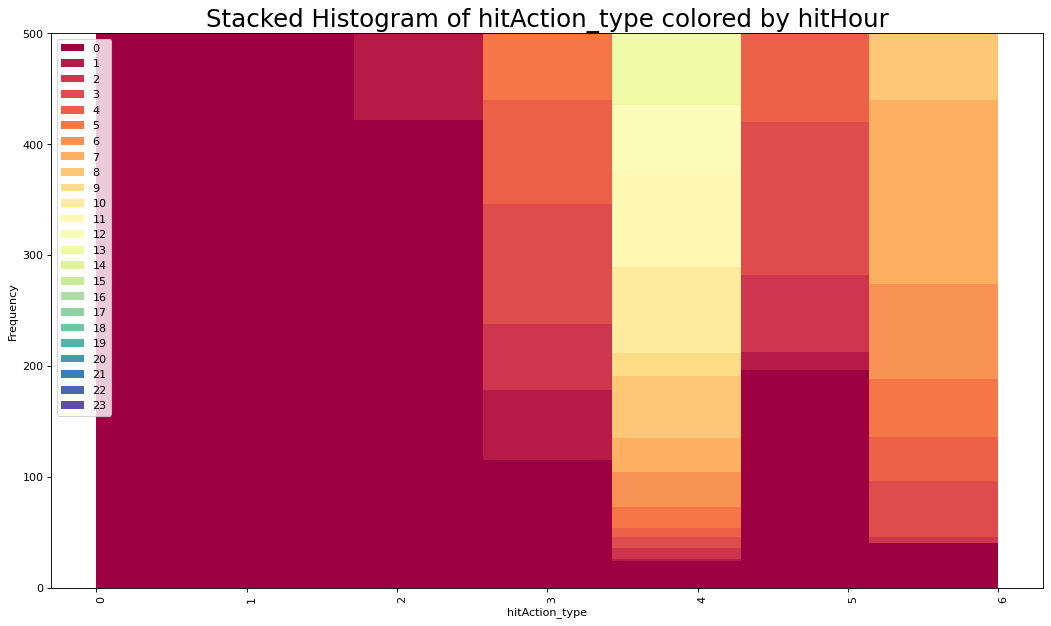

In [193]:
# Initialize parameters
x_var = 'hitAction_type'
groupby_var = 'hitHour'

# Group data by the variable of interest
df_grouped = df.groupby(groupby_var)

# Extract the values of x_var for each group
grouped_values = [group[x_var].values.tolist() for _, group in df_grouped]

# Define colors for each group
colors = [plt.cm.Spectral(i/float(len(grouped_values)-1)) for i in range(len(grouped_values))]

# Create a figure
plt.figure(figsize=(16,9), dpi=80)

# Create a stacked histogram
n, bins, patches = plt.hist(grouped_values, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(grouped_values)])

# Add a legend
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(grouped_values)])})

# Add title and labels
plt.title(f"Stacked Histogram of {x_var} colored by {groupby_var}", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")

# Set the range of y-axis
plt.ylim(0, 500)

# Get unique values of x_var
unique_x_var = np.unique(df[x_var]).tolist()

# Use arange to generate ticks locations
bins = np.arange(len(unique_x_var))

# Set the labels of x-axis
plt.xticks(ticks=bins, labels=unique_x_var, rotation=90, horizontalalignment='left')


# Display the plot
plt.show()


(array([ 40.,   0.,   6.,  50.,  40.,  52.,  86., 166., 298., 156., 296.,
        378., 362., 302., 258., 204., 214., 176., 314., 230., 104.,  84.,
         40.,  24.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

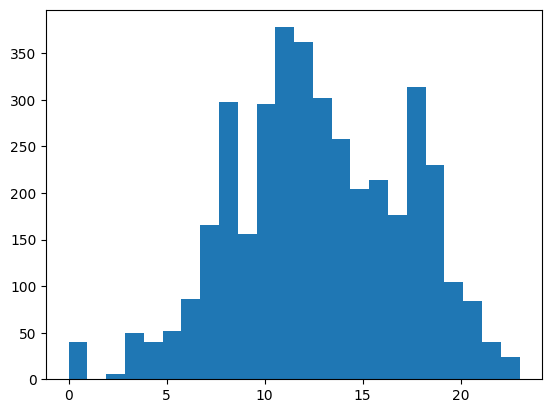

In [194]:
### แสดงการซื้อ (hitAction_type = 6) แจงแจงตามช่วงเวลา

bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([22011., 20836., 17807., 16511., 17866., 23204., 28773., 34309.,
        41773., 45066., 55886., 59403., 49586., 53460., 50273., 40598.,
        41683., 36184., 36316., 31854., 36670., 31523., 32674., 29637.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

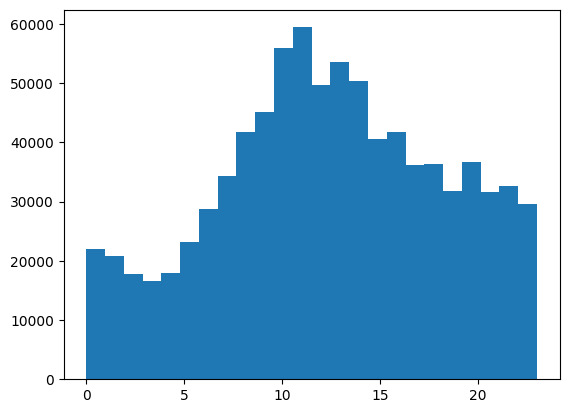

In [195]:
### แสดงการไม่ซื้อ (hitAction_type = 0) แจงแจงตามช่วงเวลา

bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 0).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

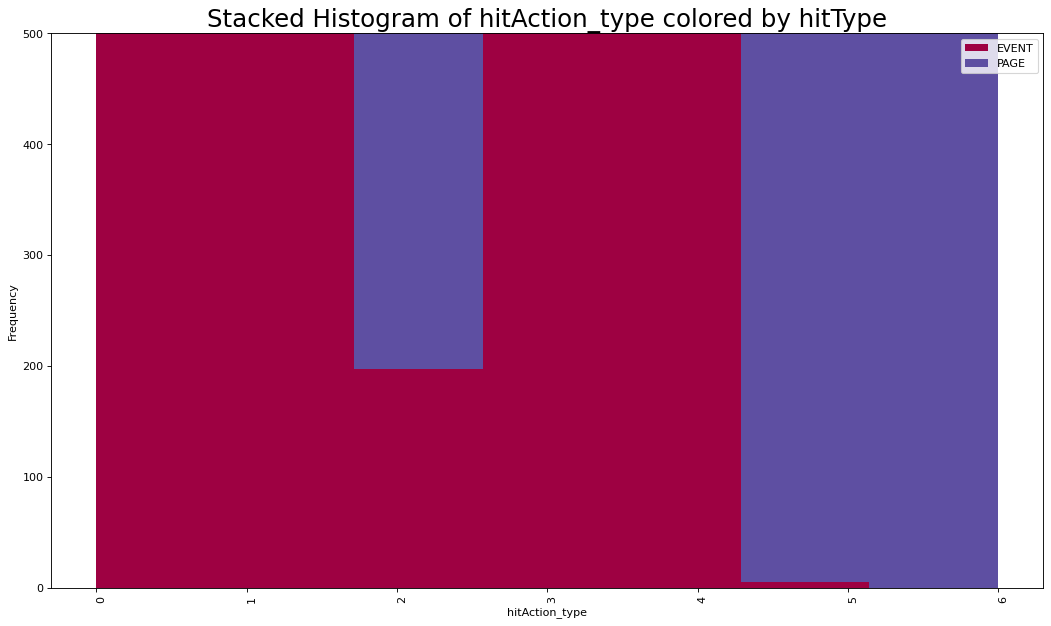

In [196]:
# Initialize parameters
x_var = 'hitAction_type'
groupby_var = 'hitType'

# Group data by the variable of interest
df_grouped = df.groupby(groupby_var)

# Extract the values of x_var for each group
grouped_values = [group[x_var].values.tolist() for _, group in df_grouped]

# Define colors for each group
colors = [plt.cm.Spectral(i/float(len(grouped_values)-1)) for i in range(len(grouped_values))]

# Create a figure
plt.figure(figsize=(16,9), dpi=80)

# Create a stacked histogram
n, bins, patches = plt.hist(grouped_values, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(grouped_values)])

# Add a legend
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(grouped_values)])})

# Add title and labels
plt.title(f"Stacked Histogram of {x_var} colored by {groupby_var}", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")

# Set the range of y-axis
plt.ylim(0, 500)

# Get unique values of x_var
unique_x_var = np.unique(df[x_var]).tolist()

# Use arange to generate ticks locations
bins = np.arange(len(unique_x_var))

# Set the labels of x-axis
plt.xticks(ticks=bins, labels=unique_x_var, rotation=90, horizontalalignment='left')


# Display the plot
plt.show()


### Finding out partial duplicated records - Spurious Patterns

*โค้ดด้านล่างแสดงให้เห็นว่า มีลูกค้ากี่ราย*

In [197]:
raw_df.select(sparkf.countDistinct('fullVisitorId').alias('num_unique_user')).show()

+---------------+
|num_unique_user|
+---------------+
|          18006|
+---------------+



*โค้ดด้านล่างแสดงให้เห็นว่า ลูกค้าแต่ละราย (fullVisitorId) ที่เข้ามาได้หลายครั้ง (visitId) นั้นเกิด Hit ได้ตั้งแต่ 1 ครั้งขึ้นไป*

In [198]:
sessionWindow = W.partitionBy('fullVisitorId','visitId').orderBy(sparkf.col("hitNumber").cast("long"))\
                 .rangeBetween(-sys.maxsize, sys.maxsize)

In [199]:
allHit = sparkf.expr("count('hitNumber')")

In [200]:
raw_df.withColumn('numHit',allHit.over(sessionWindow))\
.select('fullVisitorId','visitId','numHit')\
.distinct().orderBy('fullVisitorId','visitId').show(7)

+----------------+----------+------+
|   fullVisitorId|   visitId|numHit|
+----------------+----------+------+
| 514359656957582|1481535186|    24|
| 526704849855859|1492044399|    12|
|5046942961392781|1486511444|    60|
|5046942961392781|1486514836|    12|
|5123065735856055|1470410433|    84|
|5134451956558008|1486960913|    12|
|5134451956558008|1486964401|    12|
+----------------+----------+------+
only showing top 7 rows



*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [201]:
raw_df.filter((sparkf.col('fullVisitorId') == '4991536060599177108')&(sparkf.col('VisitId') == '1495501367'))\
.count()

12

*โค้ดด้านล่างแสดงให้เห็นว่า บาง visitId เท่านั้นนั้นที่มี hitAction_type เป็นเลข 6*

In [202]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter(sparkf.col('sum_hitAction_type_6')>=1)\
      .select(['fullVisitorId','visitId','sum_hitAction_type_6'])\
      .distinct().orderBy('fullVisitorId','visitId').show()

+------------------+----------+--------------------+
|     fullVisitorId|   visitId|sum_hitAction_type_6|
+------------------+----------+--------------------+
| 52868681653220057|1487247308|                   6|
| 52947395050573230|1473344657|                   4|
| 53866968780969645|1481914028|                   2|
|500766381427960566|1489605660|                   6|
|500771270741221130|1481728507|                   8|
|500926353574528949|1491191147|                   6|
|502027330594674519|1488479930|                   2|
|502427268661784166|1475681795|                   4|
|507378123137078709|1492017734|                  12|
|512376512516526849|1484413414|                   2|
|512988788718016553|1494940948|                   4|
|513403330506317388|1484058394|                   6|
|513403330506317388|1488427898|                   4|
|514366605460721708|1481841909|                   6|
|514478324726152361|1480456502|                   4|
|514517908760071241|1485384182|               

*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [203]:
raw_df.filter(sparkf.col('totalTransactionRevenue') >=0)\
.groupBy('fullVisitorId','visitId').count().alias('numHit').orderBy('fullVisitorId','visitId').show()

+------------------+----------+-----+
|     fullVisitorId|   visitId|count|
+------------------+----------+-----+
| 52868681653220057|1487247308|  102|
| 52947395050573230|1473344657|   43|
| 53866968780969645|1481914028|   97|
|500766381427960566|1489605660|  136|
|500771270741221130|1481728507|  162|
|500926353574528949|1491191147|   39|
|502027330594674519|1488479930|   17|
|502427268661784166|1475681795|  158|
|507378123137078709|1492017734|  172|
|512376512516526849|1484413414|   67|
|512988788718016553|1494940948|   30|
|513403330506317388|1484058394|  119|
|513403330506317388|1488427898|   42|
|514366605460721708|1481841909|   18|
|514478324726152361|1480456502|   46|
|514517908760071241|1485384182|   25|
|515195001502319520|1480385724|  177|
|515770511624914543|1493699819|   71|
|515770511624914543|1494428047|   70|
|516734366347147622|1478384303|  192|
+------------------+----------+-----+
only showing top 20 rows



In [204]:
raw_df.filter(sparkf.col('hitAction_type')==6)\
      .select('fullVisitorId','visitId').groupBy('fullVisitorId','visitId').count()\
      .orderBy('fullVisitorId','visitId').show()

+------------------+----------+-----+
|     fullVisitorId|   visitId|count|
+------------------+----------+-----+
| 52868681653220057|1487247308|    6|
| 52947395050573230|1473344657|    4|
| 53866968780969645|1481914028|    2|
|500766381427960566|1489605660|    6|
|500771270741221130|1481728507|    8|
|500926353574528949|1491191147|    6|
|502027330594674519|1488479930|    2|
|502427268661784166|1475681795|    4|
|507378123137078709|1492017734|   12|
|512376512516526849|1484413414|    2|
|512988788718016553|1494940948|    4|
|513403330506317388|1484058394|    6|
|513403330506317388|1488427898|    4|
|514366605460721708|1481841909|    6|
|514478324726152361|1480456502|    4|
|514517908760071241|1485384182|    2|
|515195001502319520|1480385724|    8|
|515770511624914543|1493699819|    4|
|515770511624914543|1494428047|    4|
|516734366347147622|1478384303|    4|
+------------------+----------+-----+
only showing top 20 rows



In [205]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4995924842281653133')&(sparkf.col('VisitId') == '1486131356'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'numHit','hitAction_type_6','sum_hitAction_type_6'])\
      .orderBy('hitNumber').show()

+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|      fullVisitorId|   visitId|hitNumber|timeMicroSec|hitAction_type|numHit|hitAction_type_6|sum_hitAction_type_6|
+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|    75|               0|                   6|
|4995924842281653133|1486131356|        2|       11890|             0|  

In [206]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'numHit','hitAction_type_6','sum_hitAction_type_6'])\
      .orderBy('hitNumber').show(100)

+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|      fullVisitorId|   visitId|hitNumber|timeMicroSec|hitAction_type|numHit|hitAction_type_6|sum_hitAction_type_6|
+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|  

In [207]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
      .count()

55

*โค้ดด้านล่างแสดงให้เห็นว่า บาง visitId เท่านั้นนั้นที่ hitAction_type ตัวสุดท้ายเป็นเลข 6*

In [208]:
Get_lastHitAction_Type = sparkf.last(sparkf.col('hitAction_type').cast(IntegerType()))

In [209]:
raw_df.withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('lastHitAction_type',Get_lastHitAction_Type.over(sessionWindow))\
      .select('fullVisitorId','visitId','numHit','lastHitAction_type')\
      .filter(sparkf.col('lastHitAction_type') == 6)\
      .distinct().orderBy('fullVisitorId','visitId').show()

+------------------+----------+------+------------------+
|     fullVisitorId|   visitId|numHit|lastHitAction_type|
+------------------+----------+------+------------------+
| 52868681653220057|1487247308|   102|                 6|
| 52947395050573230|1473344657|    43|                 6|
| 53866968780969645|1481914028|    97|                 6|
|500766381427960566|1489605660|   136|                 6|
|500771270741221130|1481728507|   162|                 6|
|500926353574528949|1491191147|    39|                 6|
|502027330594674519|1488479930|    17|                 6|
|502427268661784166|1475681795|   158|                 6|
|507378123137078709|1492017734|   172|                 6|
|512376512516526849|1484413414|    67|                 6|
|512988788718016553|1494940948|    30|                 6|
|513403330506317388|1484058394|   119|                 6|
|513403330506317388|1488427898|    42|                 6|
|514366605460721708|1481841909|    18|                 6|
|5144783247261

In [210]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
.filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
.select(customerBehaviorCol_list)\
.orderBy('hitNumber').show(100)

+--------+----------+---------+--------------+---------+------------+--------------------+----------+-----------------------+
|  source|   visitId|newVisits|hitAction_type|hitNumber|timeMicroSec|       v2ProductName|timeOnSite|totalTransactionRevenue|
+--------+----------+---------+--------------+---------+------------+--------------------+----------+-----------------------+
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Long...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Shor...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Shor...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|YouTube Men's Sho...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Perf...|       349|               50

# 3. Data Preparation

In [211]:
# Drop columns
# 'source', 'sourceKeyword', 'isVideoAd', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen'

# onehot
# 'productListName', 'dayofweek', 'hitAction_type'

# standardization (don't need)
# 'timeOnSite', 'totalTransactionRevenue'

*โค้ดด้านล่าง แสดงการตรวจหาค่า null ว่าอยู่ที่ column และ row ใด*

In [212]:
raw_df.filter(reduce(lambda a1, a2: a1 | a2,\
                     (sparkf.col(c).isNull() \
                      for c in raw_df.columns))).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,917804,917805,917806,917807,917808,917809,917810,917811,917812,917813
source,google,google,google,google,google,google,google,google,google,google,...,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua,google.com.ua
isTrueDirect,True,True,True,True,True,True,True,True,True,True,...,None,None,None,None,None,None,None,None,None,None
sourceKeyword,(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),...,None,None,None,None,None,None,None,None,None,None
medium,organic,organic,organic,organic,organic,organic,organic,organic,organic,organic,...,referral,referral,referral,referral,referral,referral,referral,referral,referral,referral
isVideoAd,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
fullVisitorId,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,...,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454,548755853977389454
visitId,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,...,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393,1478328393
date,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,...,20161104,20161104,20161104,20161104,20161104,20161104,20161104,20161104,20161104,20161104
newVisits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
hitReferer,None,None,None,None,None,None,None,None,None,None,...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...,https://www.google.com.ua/imgres?imgurl=https%...


In [213]:
df2 = raw_df.withColumn('isTrueDirect', sparkf.when(raw_df.isTrueDirect == 'true', 1).otherwise(0)) \
.withColumn('medium_organic', sparkf.when(raw_df.medium == 'organic', 1).otherwise(0)) \
.withColumn('dayofweek', sparkf.dayofweek(sparkf.to_date(sparkf.col('date').cast('string'), 'yyyyMMdd'))) \
.withColumn('newVisits', sparkf.when(raw_df.newVisits == '1', 1).otherwise(0)) \
.withColumn('hitType_page', sparkf.when(raw_df.hitType == 'PAGE', 1).otherwise(0)) \
.withColumn('purchased', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.withColumn('hitHour_00_02', sparkf.when((raw_df.hitHour >= 0) & (raw_df.hitHour <= 2), 1).otherwise(0)) \
.withColumn('hitHour_03_05', sparkf.when((raw_df.hitHour >= 3) & (raw_df.hitHour <= 5), 1).otherwise(0)) \
.withColumn('hitHour_06_08', sparkf.when((raw_df.hitHour >= 6) & (raw_df.hitHour <= 8), 1).otherwise(0)) \
.withColumn('hitHour_09_11', sparkf.when((raw_df.hitHour >= 9) & (raw_df.hitHour <= 11), 1).otherwise(0)) \
.withColumn('hitHour_12_14', sparkf.when((raw_df.hitHour >= 12) & (raw_df.hitHour <= 14), 1).otherwise(0)) \
.withColumn('hitHour_15_17', sparkf.when((raw_df.hitHour >= 15) & (raw_df.hitHour <= 17), 1).otherwise(0)) \
.withColumn('hitHour_18_20', sparkf.when((raw_df.hitHour >= 18) & (raw_df.hitHour <= 20), 1).otherwise(0)) \
.withColumn('hitHour_21_23', sparkf.when((raw_df.hitHour >= 21) & (raw_df.hitHour <= 23), 1).otherwise(0)) \
.withColumn('hitMin_00_14', sparkf.when((raw_df.hitMin >= 0) & (raw_df.hitHour < 15), 1).otherwise(0)) \
.withColumn('hitMin_15_29', sparkf.when((raw_df.hitMin >= 15) & (raw_df.hitHour < 30), 1).otherwise(0)) \
.withColumn('hitMin_30_44', sparkf.when((raw_df.hitMin >= 30) & (raw_df.hitHour < 45), 1).otherwise(0)) \
.withColumn('hitMin_45_60', sparkf.when((raw_df.hitMin >= 45) & (raw_df.hitHour < 60), 1).otherwise(0)) \
.withColumn('isClick', sparkf.when(raw_df.isClick, 1).otherwise(0)) \
.withColumn('isImpression', sparkf.when(raw_df.isImpression, 1).otherwise(0)) \
.withColumn('hitaction_1', sparkf.when(raw_df.hitAction_type == 1, 1).otherwise(0)) \
.withColumn('hitaction_2', sparkf.when(raw_df.hitAction_type == 2, 1).otherwise(0)) \
.withColumn('hitaction_3', sparkf.when(raw_df.hitAction_type == 3, 1).otherwise(0)) \
.withColumn('hitaction_4', sparkf.when(raw_df.hitAction_type == 4, 1).otherwise(0)) \
.withColumn('hitaction_5', sparkf.when(raw_df.hitAction_type == 5, 1).otherwise(0)) \
.withColumn('hitaction_6', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.na.fill(value=0, subset=['timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue'])
# .drop('source', 'medium', 'date', 'hitType', 'hitHour', 'hitMin', 'sourceKeyword', 'isVideoAd', 'fullVisitorId', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen')

In [214]:
df2.printSchema() ##Aekanun

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: integer (nullable = false)
 |-- isImpression: integer (nullable = false)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTra

In [215]:
df2.show()

+------+------------+--------------+-------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+----------------+-------+------------+-----------------+------------+----------+-----------------------+--------------+---------+------------+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+
|source|isTrueDirect| sourceKeyword| medium|isVideoAd|      fullVisitorId|   visitId|    date|newVisits|hitReferer|hitType|hitAction_type|hitNumber|hitHour|hitMin|timeMicroSec|       v2ProductName| productListName|isClick|isImpression|sessionQualityDim|timeOnScreen|timeOnSite|totalTransactionRevenue|medium_organic|dayofweek|hitType_page|purchased|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_1

In [216]:
df2.filter(df2.hitaction_6 >= 1).groupBy('productListName').count().show()

+---------------+-----+
|productListName|count|
+---------------+-----+
|      (not set)| 3880|
+---------------+-----+



In [217]:
df3 = df2.groupBy('fullVisitorId', 'visitId', 'v2ProductName', 
                  'isTrueDirect', 'medium_organic', 'dayofweek',
                  'newVisits', 'hitType_page',
                  'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 
                  'hitHour_12_14', 'hitHour_15_17',  'hitHour_18_20', 'hitHour_21_23', 
                  ) \
.agg(sparkf.sum('hitaction_1').alias('sum_hitaction_1')
, sparkf.sum('hitaction_2').alias('sum_hitaction_2')
, sparkf.sum('hitaction_3').alias('sum_hitaction_3')
, sparkf.sum('hitaction_4').alias('sum_hitaction_4')
, sparkf.sum('hitaction_5').alias('sum_hitaction_5')
, sparkf.sum('hitaction_6').alias('sum_hitaction_6')
, sparkf.max('hitNumber').alias('hitNumber')
, sparkf.max('timeOnSite').alias('timeOnSite')
, sparkf.max('sessionQualityDim').alias('sessionQualityDim')
, sparkf.max('totalTransactionRevenue').alias('totalTransactionRevenue')
, sparkf.max('isClick').alias('isClick')
, sparkf.max('isImpression').alias('isImpression')
)

In [218]:
df3 = df3.withColumn('target', sparkf.when(df3.sum_hitaction_6 >= 1, 1).otherwise(0))

In [219]:
df3.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,636420,4.7591779043847281E18,1.43788778900571622E18,514359656957582,5487531102128447544
visitId,636420,1.4832625402124038E9,9721153.907150326,1470037326,1501656575
v2ProductName,636420,None,None,"""7"""" Dog Frisbee""",YouTube Youth Short Sleeve Tee Red
isTrueDirect,636420,0.3486078375915276,0.4765299255774966,0,1
medium_organic,636420,0.3322585713836774,0.47102352567253536,0,1
dayofweek,636420,3.9352424499544325,1.8421856927605031,1,7
newVisits,636420,0.7284466232990793,0.44476111691991926,0,1
hitType_page,636420,0.9757660035825398,0.15377498818397697,0,1
hitHour_00_02,636420,0.07368718770623173,0.26126135061745115,0,1


*โค้ดด้านล่าง แสดงการนับจำนวนค่า null ที่อาจหลงเหลืออยู่จากการ cleansing and transformation*

In [220]:
df3.select([sparkf.count(sparkf.when(sparkf.col(col).isNull(),True)).alias(col) for col in df3.columns]).show()

+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+
|fullVisitorId|visitId|v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|
+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------

In [221]:
df3.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- medium_organic: integer (nullable = false)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitType_page: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = tr

In [222]:
df3.groupBy('sum_hitaction_1', 'target').count().sort('sum_hitaction_1').show()

+---------------+------+------+
|sum_hitaction_1|target| count|
+---------------+------+------+
|              0|     0|621341|
|              0|     1|  1798|
|              1|     0|  7883|
|              2|     0|  3509|
|              3|     0|  1088|
|              4|     0|   463|
|              5|     0|   161|
|              6|     0|    77|
|              7|     0|    44|
|              8|     0|    14|
|              9|     0|    14|
|             10|     0|    10|
|             11|     0|     2|
|             12|     0|     3|
|             13|     0|     3|
|             14|     0|     1|
|             15|     0|     2|
|             16|     0|     1|
|             19|     0|     1|
|             21|     0|     1|
+---------------+------+------+
only showing top 20 rows



In [223]:
df3.groupBy('sum_hitaction_2', 'target').count().sort('sum_hitaction_2').show()

+---------------+------+------+
|sum_hitaction_2|target| count|
+---------------+------+------+
|              0|     0|622274|
|              0|     1|   757|
|              1|     1|   862|
|              1|     0|  9865|
|              2|     0|  1312|
|              2|     1|   121|
|              3|     1|    39|
|              3|     0|   792|
|              4|     1|     8|
|              4|     0|   164|
|              5|     1|     6|
|              5|     0|   106|
|              6|     0|    39|
|              6|     1|     3|
|              7|     0|    31|
|              8|     0|     6|
|              8|     1|     1|
|              9|     0|    14|
|             10|     0|     3|
|             11|     0|     2|
+---------------+------+------+
only showing top 20 rows



In [224]:
df3.groupBy('sum_hitaction_3', 'target').count().sort('sum_hitaction_3').show()

+---------------+------+------+
|sum_hitaction_3|target| count|
+---------------+------+------+
|              0|     0|629615|
|              0|     1|  1798|
|              1|     0|  4332|
|              2|     0|   467|
|              3|     0|   112|
|              4|     0|    47|
|              5|     0|    15|
|              6|     0|    11|
|              7|     0|     5|
|              8|     0|     2|
|              9|     0|     1|
|             10|     0|     2|
|             12|     0|     4|
|             13|     0|     3|
|             14|     0|     1|
|             15|     0|     2|
|             18|     0|     1|
|             19|     0|     1|
|             21|     0|     1|
+---------------+------+------+



In [225]:
df3.groupBy('sum_hitaction_4', 'target').count().sort('sum_hitaction_4').show()

+---------------+------+------+
|sum_hitaction_4|target| count|
+---------------+------+------+
|              0|     0|633835|
|              0|     1|  1798|
|              1|     0|   732|
|              2|     0|    36|
|              3|     0|    12|
|              4|     0|     1|
|              5|     0|     3|
|              6|     0|     1|
|              8|     0|     1|
|             12|     0|     1|
+---------------+------+------+



In [226]:
df3.groupBy('sum_hitaction_5', 'target').count().sort('sum_hitaction_5').show()

+---------------+------+------+
|sum_hitaction_5|target| count|
+---------------+------+------+
|              0|     0|633422|
|              0|     1|     6|
|              1|     1|    17|
|              1|     0|   512|
|              2|     0|   216|
|              2|     1|    67|
|              3|     1|   530|
|              3|     0|   136|
|              4|     1|   436|
|              4|     0|   170|
|              5|     1|   248|
|              5|     0|    59|
|              6|     0|    29|
|              6|     1|   150|
|              7|     0|    23|
|              7|     1|    70|
|              8|     1|   114|
|              8|     0|     2|
|              9|     0|    22|
|              9|     1|    54|
+---------------+------+------+
only showing top 20 rows



## Data Encoding

In [227]:
# productList_indexer = StringIndexer(inputCol='productListName', outputCol='productList_index')
# productList_ohe = OneHotEncoder(inputCol='productList_index', outputCol='productList_vec')

In [228]:
# onehot_encoder = OneHotEncoder(inputCols=['hitAction_type', 'dayofweek'], outputCols=['hitAction_type_vec', 'dayofweek_vec'])
onehot_encoder = OneHotEncoder(inputCols=['dayofweek'], outputCols=['dayofweek_vec'])

In [229]:
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')

In [230]:
df3.schema.names

['fullVisitorId',
 'visitId',
 'v2ProductName',
 'isTrueDirect',
 'medium_organic',
 'dayofweek',
 'newVisits',
 'hitType_page',
 'hitHour_00_02',
 'hitHour_03_05',
 'hitHour_06_08',
 'hitHour_09_11',
 'hitHour_12_14',
 'hitHour_15_17',
 'hitHour_18_20',
 'hitHour_21_23',
 'sum_hitaction_1',
 'sum_hitaction_2',
 'sum_hitaction_3',
 'sum_hitaction_4',
 'sum_hitaction_5',
 'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'isClick',
 'isImpression',
 'target']

In [231]:
# vector_assembler = VectorAssembler\
# (inputCols = ['isTrueDirect', 'newVisits', 'hitAction_type_vec', 'hitNumber', 'isClick', 'isImpression', 'sessionQualityDim', 'timeOnSite', 'totalTransactionRevenue', \
#  'medium_organic', 'hitType_page', 'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 'hitHour_12_14', 'hitHour_15_17', 'hitHour_18_20', \
#  'hitHour_21_23', 'hitMin_00_14', 'hitMin_15_29', 'hitMin_30_44', 'hitMin_45_60', \
#  'dayofweek_vec', 'hitAction_type_vec', 'productList_vec'], outputCol = 'features')

In [232]:
vector_assembler = VectorAssembler\
(inputCols = [\
              ###'isTrueDirect',
 ###'medium_organic',
 ###'dayofweek_vec',
 'newVisits',
 ###'hitType_page',
 ###'hitHour_00_02',
 ###'hitHour_03_05',
 ###'hitHour_06_08',
 ###'hitHour_09_11',
 ###'hitHour_12_14',
 ###'hitHour_15_17',
 ###'hitHour_18_20',
 ###'hitHour_21_23',
 ###'sum_hitaction_1',
 'sum_hitaction_2',
 ###'sum_hitaction_3',
 ###'sum_hitaction_4',
#  'sum_hitaction_5',
#  'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 ###'sessionQualityDim',
 ###'isClick',
 'isImpression'\
 ], outputCol = 'features')

In [233]:
# pipeline = Pipeline(stages=[productList_indexer, productList_ohe, onehot_encoder, label_stringIdx, vector_assembler])
pipeline = Pipeline(stages=[onehot_encoder, label_stringIdx, vector_assembler])


In [234]:
final_df = pipeline.fit(df3).transform(df3)
final_df.show()

+-------------------+----------+--------------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+-------------+-----+--------------------+
|      fullVisitorId|   visitId|       v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|dayofweek_vec|label|            features|
+-------------------+----------+--------------------+------------+--------------+---------

In [235]:
raw_df.count() ##Aekanun

917814

In [236]:
df3.count() ##Aekanun

636420

## Split data

In [237]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Test Dataset: " + str(test_df.count()))

Training Dataset: 509447
Test Dataset: 126973


In [238]:
train_df.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|508010|
|  1.0|  1437|
+-----+------+



In [239]:
test_df.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|126612|
|  1.0|   361|
+-----+------+



## Oversampling

In [240]:
balanceRatio = train_df.filter(sparkf.col('label') == 1).count() / train_df.count()

In [241]:
balanceRatio

0.002820705588608825

In [242]:
calWeight = sparkf.udf(lambda x: 1 * balanceRatio if x == 0 else (1 * (1.0 - balanceRatio)), DoubleType())

In [243]:
weighted_df = train_df.withColumn('class_weight', calWeight('label'))

# 4. Modeling

In [244]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', weightCol='class_weight', seed=49)

In [245]:
rfModel = rf.fit(weighted_df)

In [246]:
result_df = rfModel.transform(test_df.dropna())

In [247]:
result_df.select(['label', 'prediction']).filter(result_df.label == 1).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [248]:
result_df.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|123690|
|       1.0|  3283|
+----------+------+



In [249]:
result_df.groupBy('label','prediction').count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|   337|
|  0.0|       1.0|  2946|
|  1.0|       0.0|    24|
|  0.0|       0.0|123666|
+-----+----------+------+



In [250]:
featureImportances = rfModel.featureImportances.toArray()

In [251]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [252]:
ExtractFeatureImp(featureImportances, result_df, "features").head(30)

,idx,name,score
2,2,hitNumber,0.597276
4,4,isImpression,0.190031
1,1,sum_hitaction_2,0.134933
3,3,timeOnSite,0.066413
0,0,newVisits,0.011346


In [253]:
rfModel.getNumTrees

20

# 5. Evaluation

In [254]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_df))

Area Under ROC = 0.955125


In [255]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
print('F1 score = %g' % evaluator.evaluate(result_df))
print('Precision = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'precisionByLabel'}))
print('Recall = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'recallByLabel'}))

F1 score = 0.985851
Precision = 0.999806
Recall = 0.976732


## Tuning

In [256]:
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [20, 50, 100]) \
.build()

In [257]:
crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=BinaryClassificationEvaluator(), 
                          numFolds=5)

In [258]:
cvModel = crossval.fit(weighted_df)

In [259]:
result_cv_df = cvModel.transform(test_df.dropna())

In [260]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_cv_df))

Area Under ROC = 0.955208


# 6. Deployment

REST API